# OpenEarhMap Semantinc Segmentation

original implementation found at https://github.com/bao18/open_earth_map/blob/main/Demo.ipynb

---

### Requirements

In [1]:
!git clone https://github.com/bao18/open_earth_map.git

Cloning into 'open_earth_map'...
remote: Enumerating objects: 257, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 257 (delta 14), reused 18 (delta 8), pack-reused 233
Receiving objects: 100% (257/257), 5.94 MiB | 15.51 MiB/s, done.
Resolving deltas: 100% (137/137), done.


In [2]:
!pip install rasterio

In [3]:
import os
import gdown
import zipfile

url = "https://drive.google.com/uc?export=download&confirm=pbef&id=1AIIPx9t1JLi5bLhe9pxyiewyYu8LXBRv"
output = "OpenEathMap_Mini.zip"
gdown.download(url, output, quiet=False)

with zipfile.ZipFile(output, 'r') as fzip:
    fzip.extractall()
os.remove(output)

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1AIIPx9t1JLi5bLhe9pxyiewyYu8LXBRv
To: /media/gdrive8tb/riken_openearthmap/open_earth_map/OpenEathMap_Mini.zip
100%|██████████| 2.53G/2.53G [01:08<00:00, 37.0MB/s]


### Imports
---

In [19]:
import time
import warnings
import numpy as np
import torch
import open_earth_map.oem as oem
import torchvision
from pathlib import Path
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Defines main parameters

In [20]:
# Path to the OpenEarthMap directory
OEM_DATA_DIR = "OpenEarthMap_Mini/"

# Training and validation file list
TRAIN_LIST = os.path.join(OEM_DATA_DIR, "train.txt")
VAL_LIST = os.path.join(OEM_DATA_DIR, "val.txt")

IMG_SIZE = 512
N_CLASSES = 9
LR = 0.0001
BATCH_SIZE = 4
NUM_EPOCHS = 10
DEVICE = "cuda"
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

### Prepares training and validation file lists.

In [21]:
img_paths = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "/images/" in str(f)]
train_fns = [str(f) for f in img_paths if f.name in np.loadtxt(TRAIN_LIST, dtype=str)]
val_fns = [str(f) for f in img_paths if f.name in np.loadtxt(VAL_LIST, dtype=str)]

print("Total samples      :", len(img_paths))
print("Training samples   :", len(train_fns))
print("Validation samples :", len(val_fns))

Total samples      : 1068
Training samples   : 663
Validation samples : 92


### Prepares training and validation augmentations.

In [22]:
train_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Rotate(),
        oem.transforms.Crop(IMG_SIZE),
    ],
)

val_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Resize(IMG_SIZE),
    ],
)

### Defines training and validation dataloaders

In [23]:
train_data = oem.dataset.OpenEarthMapDataset(
    train_fns,
    n_classes=N_CLASSES,
    augm=train_augm,
)

val_data = oem.dataset.OpenEarthMapDataset(
    val_fns,
    n_classes=N_CLASSES,
    augm=val_augm,
)

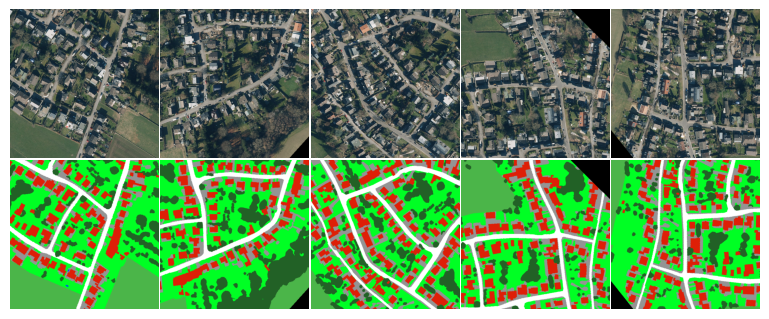

In [24]:
fig, axs = plt.subplots(2, 5, figsize=(5*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

IDX = 1
for i in range(5):
    img, msk, fn = train_data[IDX]

    img = np.moveaxis(img.numpy(), 0, -1)
    msk = oem.utils.make_rgb(np.argmax(msk.numpy(), axis=0))

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(msk)
    axs[1, i].axis("off")

plt.show()

In [25]:
train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=True,
    drop_last=True,
)
val_data_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=False,
)

### Defines the network architecture, optimizer, and criterion

In [26]:
network = oem.networks.UNet(in_channels=3, n_classes=N_CLASSES)
optimizer = torch.optim.Adam(network.parameters(), lr=LR)
criterion = oem.losses.JaccardLoss()

### Trains and validates the network

In [27]:
start = time.time()

max_score = 0
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch: {epoch + 1}")

    train_logs = oem.runners.train_epoch(
        model=network,
        optimizer=optimizer,
        criterion=criterion,
        dataloader=train_data_loader,
        device=DEVICE,
    )

    valid_logs = oem.runners.valid_epoch(
        model=network,
        criterion=criterion,
        dataloader=val_data_loader,
        device=DEVICE,
    )
    epoch_score = valid_logs["Score"]
    if max_score < epoch_score:
        max_score = epoch_score
        oem.utils.save_model(
            model=network,
            epoch=epoch,
            best_score=max_score,
            model_name="model.pth",
            output_dir=OUTPUT_DIR,
        )

print("Elapsed time: {:.3f} min".format((time.time() - start) / 60.0))


Epoch: 1


Valid: 100%|██████████| 23/23 [00:09<00:00,  2.36it/s, Loss=6.62, Score=0.103]


model saved

Epoch: 2


Valid: 100%|██████████| 23/23 [00:09<00:00,  2.43it/s, Loss=6.39, Score=0.126]


model saved

Epoch: 3


Valid: 100%|██████████| 23/23 [00:09<00:00,  2.38it/s, Loss=6.41, Score=0.125]



Epoch: 4


Valid: 100%|██████████| 23/23 [00:09<00:00,  2.43it/s, Loss=6.28, Score=0.137]


model saved

Epoch: 5


Valid: 100%|██████████| 23/23 [00:09<00:00,  2.47it/s, Loss=6.16, Score=0.147]


model saved

Epoch: 6


Valid: 100%|██████████| 23/23 [00:09<00:00,  2.45it/s, Loss=6.14, Score=0.149]


model saved

Epoch: 7


Valid: 100%|██████████| 23/23 [00:09<00:00,  2.45it/s, Loss=6.1, Score=0.153] 


model saved

Epoch: 8


Valid: 100%|██████████| 23/23 [00:09<00:00,  2.36it/s, Loss=6.26, Score=0.139]



Epoch: 9


Valid: 100%|██████████| 23/23 [00:09<00:00,  2.46it/s, Loss=6.1, Score=0.154] 


model saved

Epoch: 10


Valid: 100%|██████████| 23/23 [00:09<00:00,  2.37it/s, Loss=6.05, Score=0.157]


model saved
Elapsed time: 21.546 min


# Testing 

### Prepares testing files

In [28]:
TEST_LIST = os.path.join(OEM_DATA_DIR, "test.txt")

img_paths = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "/images/" in str(f)]
test_fns = [str(f) for f in img_paths if f.name in np.loadtxt(TEST_LIST, dtype=str)]

print("Total samples   :", len(img_paths))
print("Testing samples :", len(test_fns))

Total samples   : 1068
Testing samples : 313


### Defines test dataloader

In [29]:
test_data = oem.dataset.OpenEarthMapDataset(test_fns, n_classes=N_CLASSES, augm=None)

### Loads trained network

In [30]:
network = oem.networks.UNet(in_channels=3, n_classes=N_CLASSES)
network = oem.utils.load_checkpoint(network, model_name="model.pth", model_dir="outputs")

Loaded model:model.pth (Epoch=9, Score=0.157)


### Makes predictions

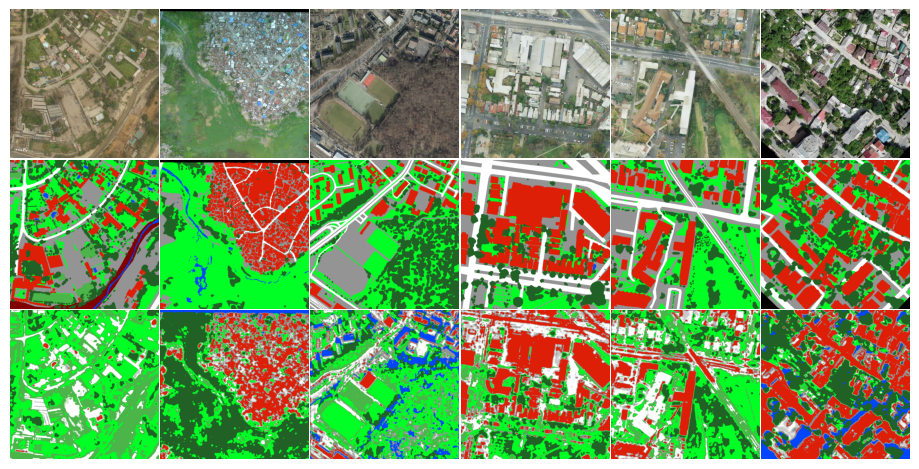

In [31]:
NPLOT = 6
idxs = np.argsort(np.random.rand(len(test_fns)))[:NPLOT]

fig, axs = plt.subplots(3, NPLOT, figsize=(NPLOT*1.5, 3*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

network.eval().to(DEVICE)
for i, idx in enumerate(idxs):
    img, msk, fn = test_data[idx]

    with torch.no_grad():
        prd = network(img.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()

    img = np.moveaxis(img.numpy(), 0, -1)
    msk = oem.utils.make_rgb(np.argmax(msk.numpy(), axis=0))
    prd = oem.utils.make_rgb(np.argmax(prd.numpy(), axis=0))

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(msk)
    axs[1, i].axis("off")
    axs[2, i].imshow(prd)
    axs[2, i].axis("off")
plt.show()